In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [9]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_layers1'

In [86]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [4]:
if 'U' in fields:
    l=len(fields)+2
else:
    l=len(fields)

df = np.empty((0,66,256,l))
df_label = np.empty((0,66,256,l))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(2295, 66, 256, 7)


In [5]:
normal=np.max(abs(df), axis=(0,1,2))
print(normal)
np.save('cfdnetplus_models/model_layers/norm',normal)

[4.41323047e+03 2.61715942e+03 6.92813654e-11 7.33556320e+07
 2.83279031e+05 1.93653164e+04 4.86423264e+01]


FileNotFoundError: [Errno 2] No such file or directory: 'cfdnetplus_models/model_layers/norm.npy'

In [6]:
n=[0,1,2,4,5,6]
df_label=df_label[:,:,:,n]
df=df[:,:,:,n]
print(df.shape)

(2295, 66, 256, 6)


In [7]:
print(df.shape)

(2295, 66, 256, 6)


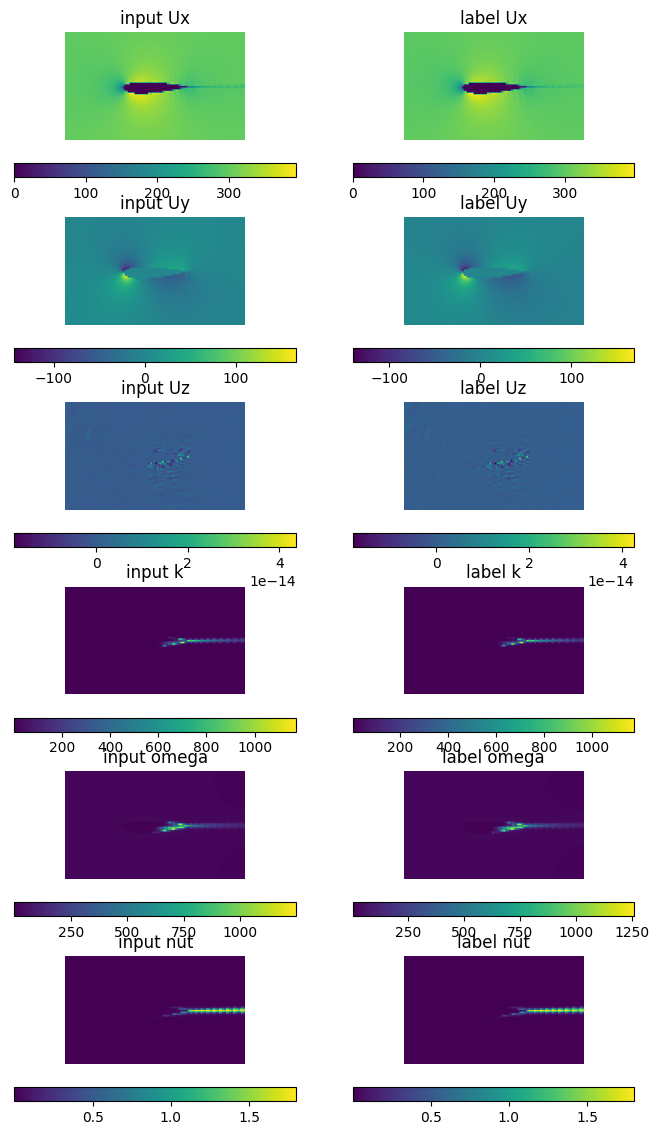

In [11]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['Ux','Uy','Uz','k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

In [10]:
#normalise U Vektors


normal=np.max(df,(0,1,2))
print(normal)

model_path='cfdnetplus_models/'+modelid+'/'

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)
print(model_path+'')

[4.41323047e+03 2.61715942e+03 5.34202092e-11 2.83279031e+05
 1.93653164e+04 4.86423264e+01]
cfdnetplus_models/model_layers1/


In [11]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [12]:
df1=df*1/normal
df_label1=df_label/normal

In [13]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

20


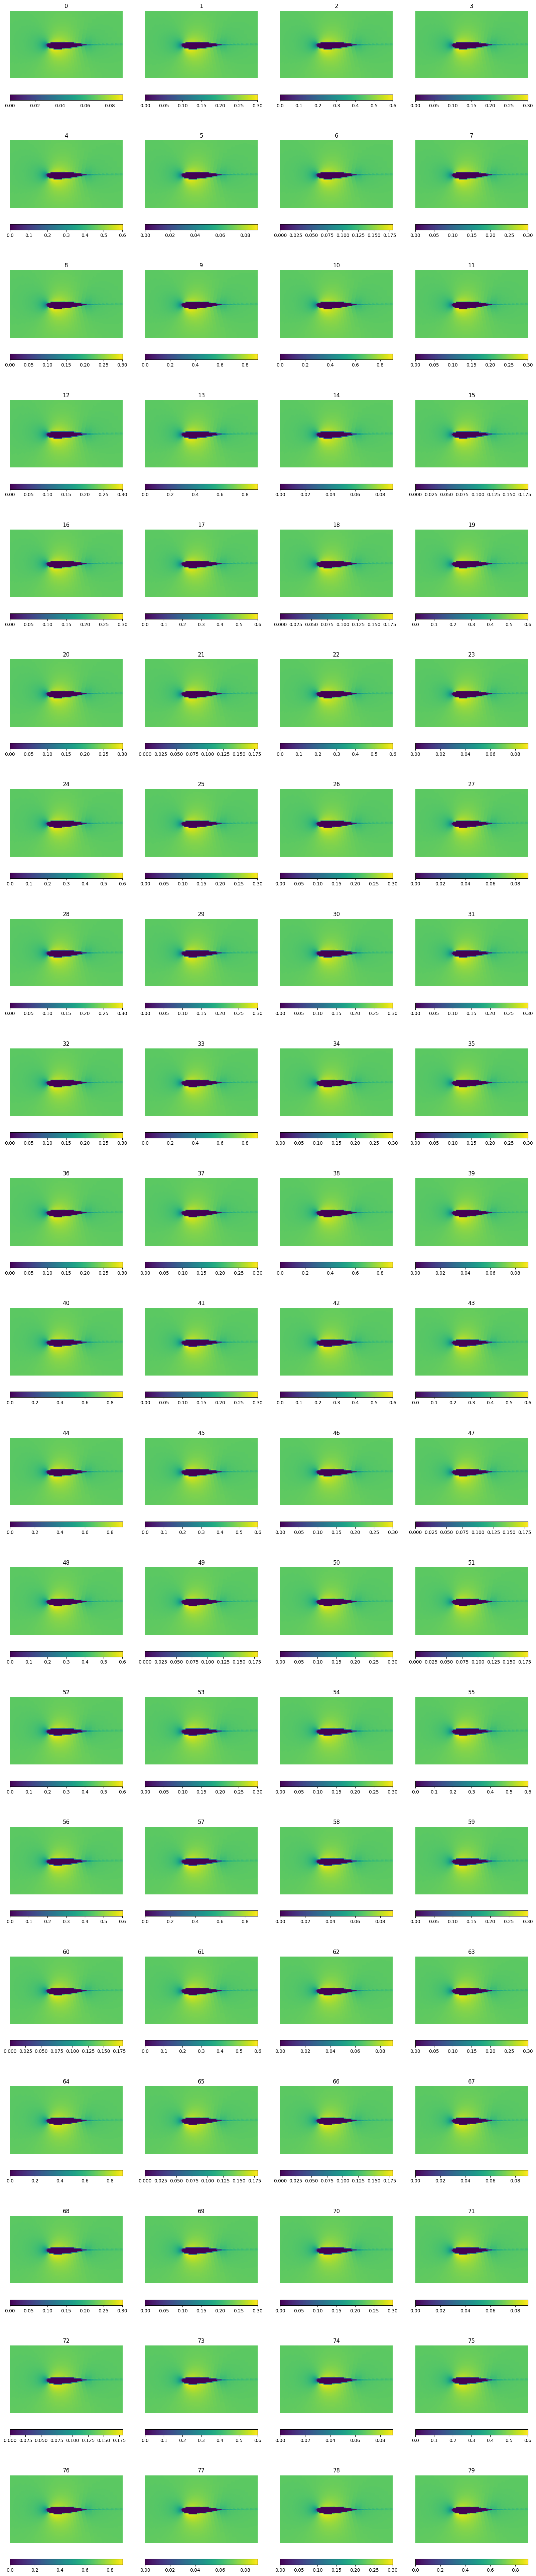

In [18]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [14]:
[a,b,c,d]=df.shape

In [15]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='linear',padding="same", input_shape=(66,256, d)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))

model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(d,(4,16),(2,8), activation='PReLU', padding="same"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 16)        4624      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        1146912   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 6)       1

In [17]:
model.compile(optimizer='adam',
              loss='mse')

In [18]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_1', 'training_10', 'training_11', 'training_12', 'training_13', 'training_14', 'training_15', 'training_16', 'training_17', 'training_18', 'training_19', 'training_2', 'training_20', 'training_21', 'training_3', 'training_4', 'training_5', 'training_6', 'training_7', 'training_8', 'training_9']
training_22


In [19]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [20]:
history = model.fit(train_data, label_train, epochs=30, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 0.0049
Epoch 1: loss improved from inf to 0.00493, saving model to training/training_22\vae_best_model_relu.epoch01-loss0.00493.w
61/61 [==============================] - 17s 274ms/step - loss: 0.0049 - val_loss: 8.4455e-04
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 5.3815e-04
Epoch 2: loss improved from 0.00493 to 0.00054, saving model to training/training_22\vae_best_model_relu.epoch02-loss0.00054.w
61/61 [==============================] - 17s 275ms/step - loss: 5.3815e-04 - val_loss: 3.8822e-04
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 3.1652e-04
Epoch 3: loss improved from 0.00054 to 0.00032, saving model to training/training_22\vae_best_model_relu.epoch03-loss0.00032.w
61/61 [==============================] - 16s 267ms/step - loss: 3.1652e-04 - val_loss: 2.5534e-04
Epoch 4/30
61/61 [==============================] - ETA: 0s - loss: 2.0886e-04
Epoch 4: loss improve

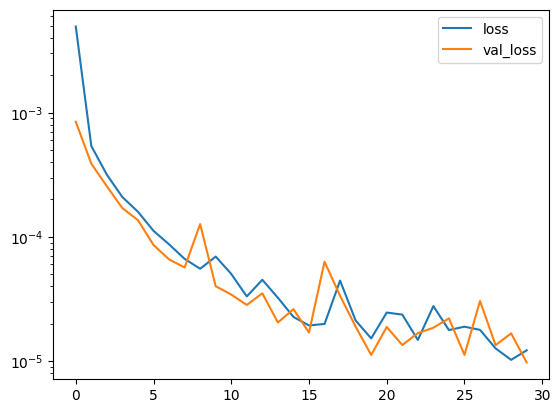

In [21]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [43]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

29
vae_best_model_relu.epoch29-loss0.00001.w


In [44]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_21/vae_best_model_relu.epoch29-loss0.00001.w


In [45]:
test=model.predict(test_data)

11/11 [==============================] - 1s 60ms/step


In [46]:
print(label_test.shape[0])
n=0
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.91561824
min: 0.0


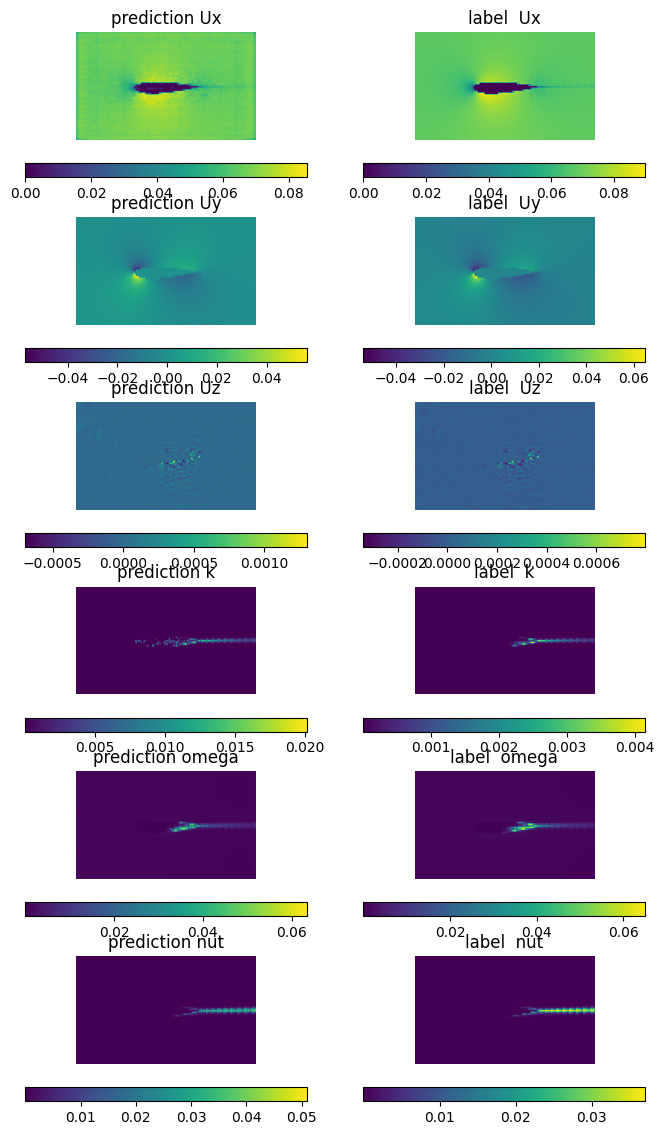

In [47]:
n=20
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
#titles= ['Ux','Uy','Uz','p']
titles= ['Ux','Uy','Uz','k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

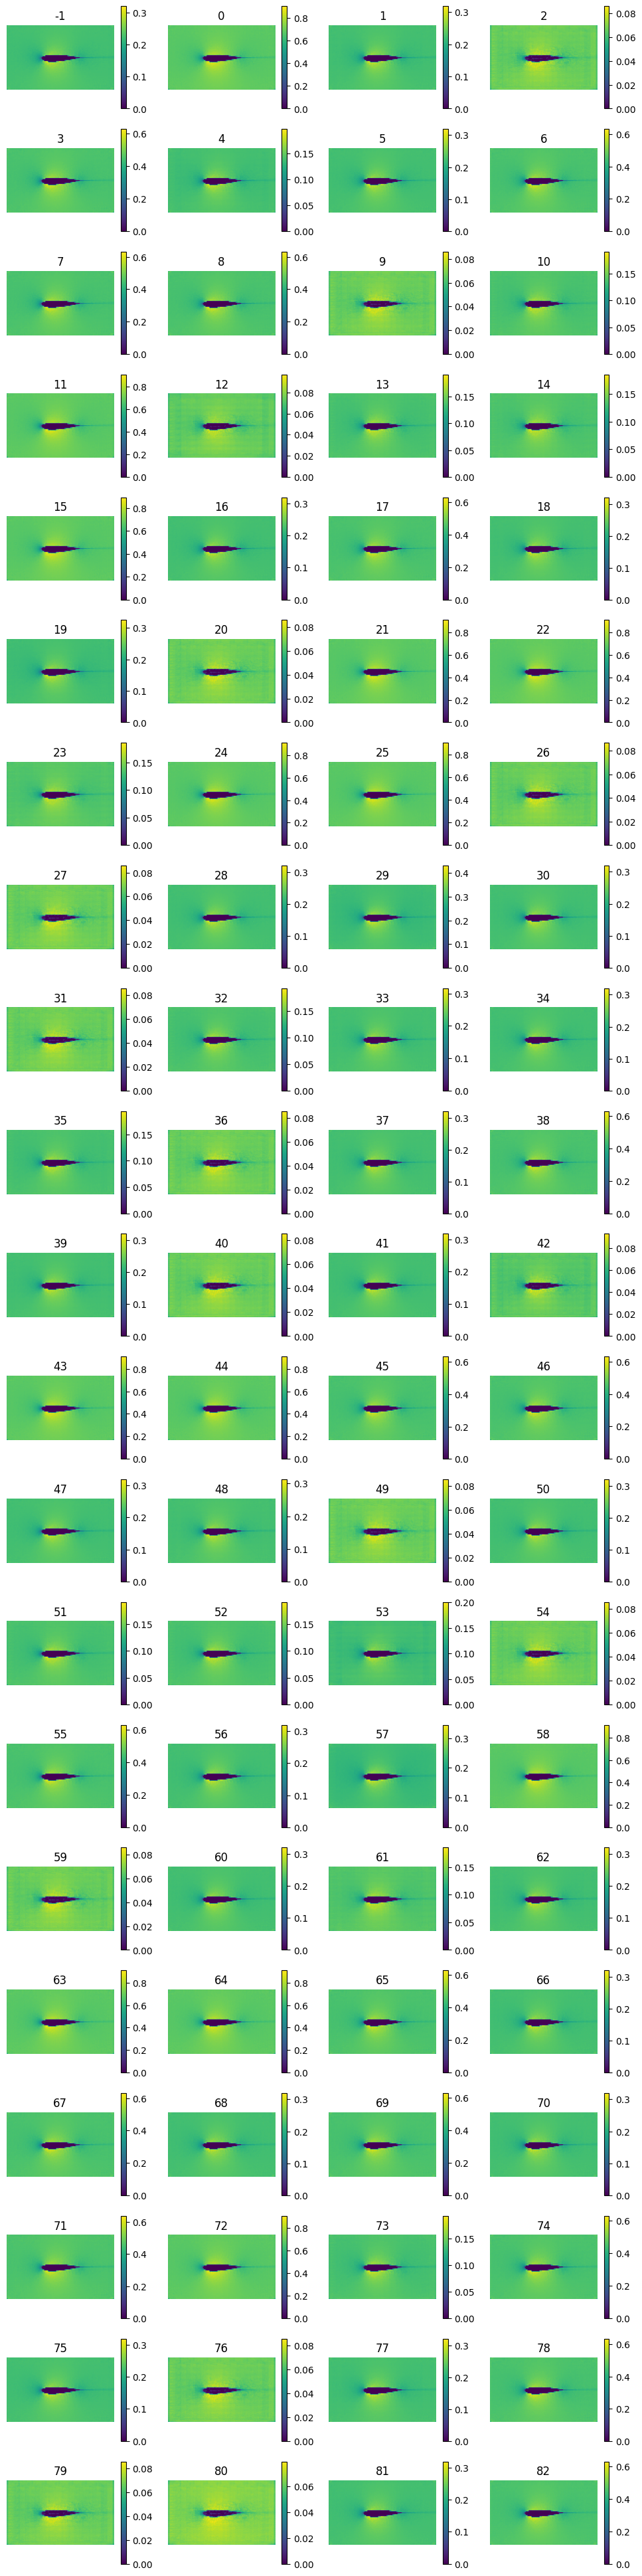

In [48]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()

In [49]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,0],label_test[i,:,:,0]))
    ssim1.append(ssim(test[i,:,:,0],label_test[i,:,:,0]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:0.009703950610316524
0.9990432243784269
6.105938892630753e-06
average ssim: 0.9969681079960214
average mse: 7.541428695455703e-05


In [113]:
print(test.shape)

(345, 66, 256, 2)


In [50]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model_sep1/model_Ukomeganut')

INFO:tensorflow:Assets written to: cfdnetplus_models/model_sep1/model_Ukomeganut\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_sep1/model_Ukomeganut\assets
